In [20]:
import networkx as nx
import matplotlib.pyplot as plt

darvis_fn = "/home/sofiya/darvis-home/darvis/darvis/essential_graph.txt"
orbslam_fn = "/home/sofiya/darvis-home/darvis-orbslam3/essential_graph.txt"

def add_node(new_node, current):
    current["nodelist"].add(new_node)
    current["G"].add_node(new_node)

    if new_node in current["loop nodes"]:
        current["inserted loop nodes"].append(new_node)
    elif new_node >= current["region nodes"][0] and new_node <= current["region nodes"][1]:
        current["inserted region nodes"].append(new_node)
    else:
        current["inserted regular nodes"].append(new_node)

            
def add_edges_of_type(line, edge_type, current):
    test_already_added = set()
    edges_vec = line.split(":")[1].rstrip().split(",")[:-1]
    for edge in edges_vec:
        left_node, right_node = map(lambda n: int(n.strip()), edge.split("->"))
        
        if not left_node in current["nodelist"]:
            add_node(left_node, current)
        if not right_node in current["nodelist"]:
            add_node(right_node, current)

        if (right_node, left_node) in test_already_added:
            print("Already have edge ", right_node, left_node)
        test_already_added.add((right_node, left_node))
        
        
        if edge_type == "loop 1":
            edge_color = 'red'
        elif edge_type == "covisible":
            edge_color = 'tab:blue'
        elif edge_type == 'span':
            edge_color = 'tab:green'
        elif edge_type == 'loop 2':
            edge_color = 'yellow'
        else:
            edge_color = 'black'
            
        current["G"].add_edge(right_node, left_node, color=edge_color)
        current["edgelist"].append((right_node, left_node))

    
def process_file(filename, loop_nodes, region_nodes, system_name):
    current = {
        "G": nx.Graph(),
        "nodelist": set(),
        "edgelist": [],
        "pos_before": {},
        "pos_after": {},
        "inserted loop nodes": [],
        "inserted regular nodes": [],
        "inserted region nodes": [],
        "loop nodes": loop_nodes,
        "region nodes": region_nodes,
    }

    for line in open(filename, "r"):
        if "Loop edges #1" in line:
            add_edges_of_type(line, "loop 1", current)
        elif "Covisible edges" in line:
            add_edges_of_type(line, "covisible", current)
        elif "Span edges" in line:    
            add_edges_of_type(line, "span", current)
        elif "Loop edges #2" in line:
            add_edges_of_type(line, "loop 2", current)
        elif "keyframe vertex" in line:
            kf_id = int(line.split("vertex")[1].split("with")[0].strip())
            if system_name == "darvis":
                x, y, z = map(lambda n: float(n.strip()), line.split("t[")[1].split("]")[0].split(","))
            elif system_name == "orbslam":
                x, y, z = map(lambda n: float(n.strip()), line.split("estimate")[1].split())
            current["pos_before"][kf_id] = [x, z]
        elif "Optimize essential graph, for kf" in line:
            kf_id = int(line.split("kf")[1].split(":")[0].strip())
            if system_name == "darvis":
                x, y, z = map(lambda n: float(n.strip()), line.split(":")[1].split("]")[0].split("[")[1].split(","))
            elif system_name == "orbslam":
                x, y, z = map(lambda n: float(n.strip()), line.split(":")[1].split())

            current["pos_after"][kf_id] = [x, z]



    return current


def cull(results):
    def bounds(node):
#         lower_bound = node >= results["loop nodes"][0] - 20 and node <= results["loop nodes"][0] + 20
#         upper_bound = node >= results["loop nodes"][1] - 30 and node <= results["loop nodes"][1] + 30

        lower_bound_region = node >= results["region nodes"][0] - 30
        upper_bound_region = node <= results["region nodes"][1] + 10
#         lower_bound_region = False
#         upper_bound_region = False
        
        lower_bound_loop = node >= results["loop nodes"][0] - 5
        upper_bound_loop = node <= results["loop nodes"][0] + 5 

        return (lower_bound_region and upper_bound_region) or (lower_bound_loop and upper_bound_loop)

    new_nodelist = []
    new_edgelist = []
    edge_colors = []
    
    for node in results["inserted regular nodes"]:
        if bounds(node):
            new_nodelist.append(node)
    
    for edge_l, edge_r in results["edgelist"]:
        if bounds(edge_l) or bounds(edge_r):
            new_edgelist.append((edge_l, edge_r))
            edge_colors.append((results["G"].get_edge_data(edge_l, edge_r)["color"]))


    return new_nodelist, new_edgelist, edge_colors
            
        
def plot(results, after_optimization):
    G = results["G"]
    loop_nodes = results["inserted loop nodes"]
    region_nodes = results["inserted region nodes"]
    
    # To show just relevant loop closure region:
    regular_nodes, edgelist, edge_colors = cull(results)

    # To show full graph:
#     regular_nodes = results["inserted regular nodes"]
#     edgelist = results["edgelist"]
#     edge_colors = [results["G"][u][v]['color'] for u,v in edgelist]

    # To graph real positions of nodes:
    if after_optimization:
        pos = results["pos_after"]
    else:
        pos = results["pos_before"]
    
    # To graph positions so graph looks nice from graphing library:
    # pos = nx.nx_agraph.graphviz_layout(results["G"])

    fig, ax = plt.subplots(figsize=(10,10))

    options = {"edgecolors": "tab:gray", "node_size": 600, "alpha": 0.9}
    nx.draw_networkx_nodes(G, pos, nodelist=regular_nodes, node_color="tab:blue", **options)
    nx.draw_networkx_nodes(G, pos, nodelist=region_nodes, node_color="orange", **options)
    nx.draw_networkx_nodes(G, pos, nodelist=loop_nodes, node_color="cyan", **options)

    nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color=edge_colors, width=1.0, alpha=0.5)

    nx.draw_networkx_labels(G, pos)
    
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

    


results_darvis = process_file(darvis_fn, [90, 874], [860, 875], "darvis")
results_orbslam = process_file(orbslam_fn, [80, 769], [759, 768], "orbslam")


/home/sofiya/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Darvis before optimization


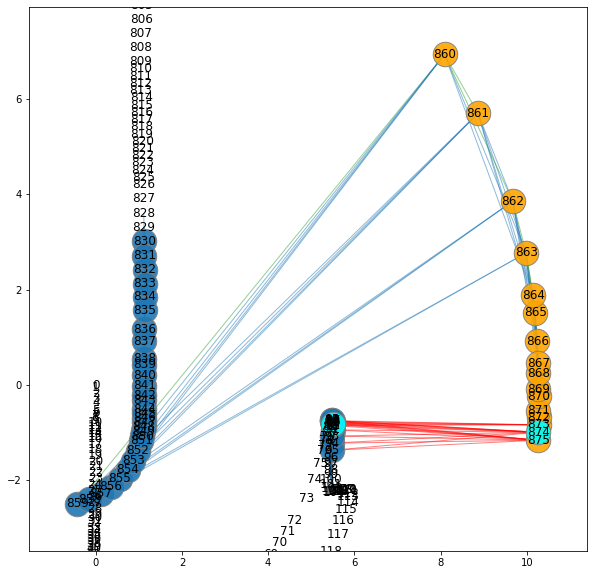

In [21]:
print("Darvis before optimization")
plot(results_darvis, 0)


Orbslam before optimization


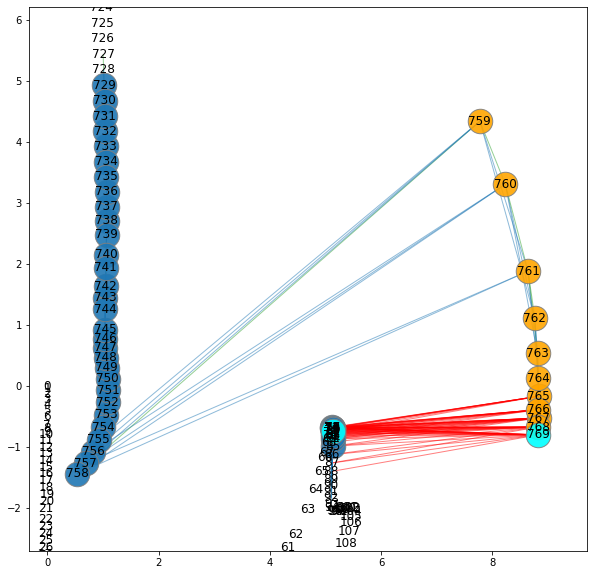

In [22]:
print("Orbslam before optimization")
plot(results_orbslam, 0)


In [23]:
# Edge colors:
# loop 1 ... red (weight > min_feat)
# covisible ... blue (covisibles where weight > min_feat)
# span ... green (parent)
# loop 2 ... yellow (loop edges in kf ... doesn't seem to be any)

# darvis - [88, 863], [847, 862]
# orbslam -[80, 769], [759, 768]

print(len(results_darvis["G"].edges()))


for nbr, datadict in results_darvis["G"].adj[846].items():
    print(nbr, datadict)
    
    
print()
for nbr, datadict in results_orbslam["G"].adj[758].items():
    print(nbr, datadict)
    
# print()
# for (l, r) in results_orbslam["G"].edges():
#     if results_orbslam["G"].get_edge_data(l, r)['color'] == 'red':
#         print(l, r)
        

6724
849 {'color': 'tab:blue'}
845 {'color': 'tab:green'}
844 {'color': 'tab:blue'}
843 {'color': 'tab:blue'}
842 {'color': 'tab:blue'}
841 {'color': 'tab:blue'}
840 {'color': 'tab:blue'}
838 {'color': 'tab:blue'}
839 {'color': 'tab:blue'}
854 {'color': 'tab:blue'}
851 {'color': 'tab:blue'}
848 {'color': 'tab:blue'}
856 {'color': 'tab:blue'}
853 {'color': 'tab:blue'}
850 {'color': 'tab:blue'}
847 {'color': 'tab:green'}
855 {'color': 'tab:blue'}
852 {'color': 'tab:blue'}

757 {'color': 'tab:green'}
756 {'color': 'tab:blue'}
755 {'color': 'tab:blue'}
754 {'color': 'tab:blue'}
759 {'color': 'tab:green'}
760 {'color': 'tab:blue'}
761 {'color': 'tab:blue'}


Darvis after optimization


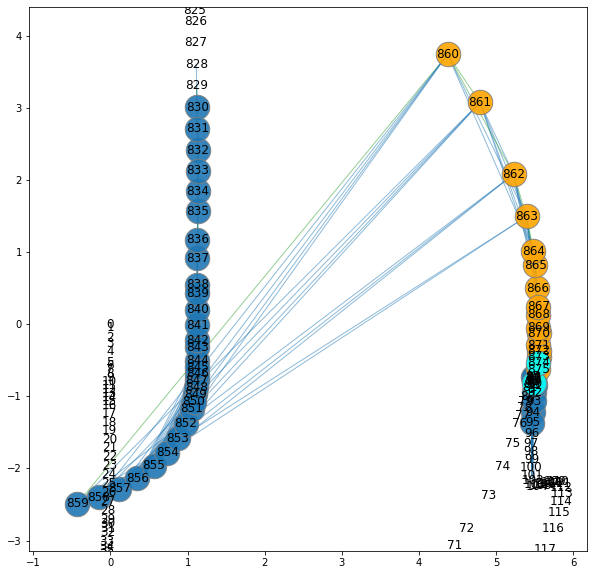

In [24]:
print("Darvis after optimization")

plot(results_darvis, 1)

Orbslam after optimization


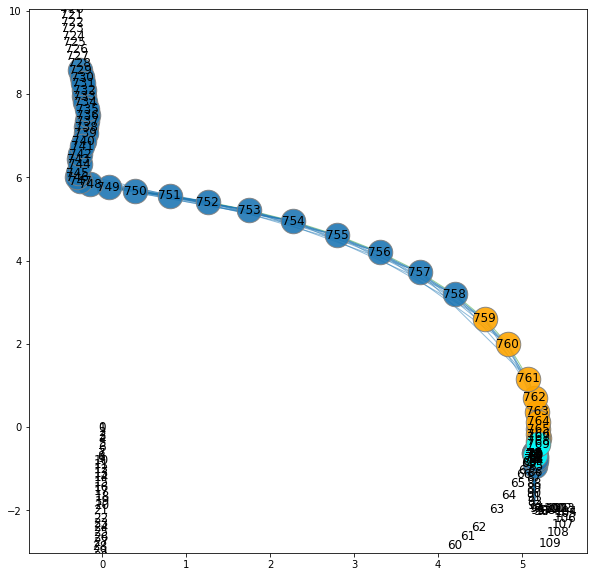

In [25]:
print("Orbslam after optimization")


plot(results_orbslam, 1)

In [19]:


# darvis_fn = "/home/sofiya/darvis-home/darvis/darvis/0_DARVIS_AFTER_OPTIMIZATION.g2o"
# orbslam_fn = "/home/sofiya/darvis-home/darvis-orbslam3/After_optimization.txt"

darvis_fn = "/home/sofiya/darvis-home/darvis/darvis/0_DARVIS_BEFORE_OPTIMIZATION.g2o"
orbslam_fn = "/home/sofiya/darvis-home/darvis-orbslam3/Before_optimization.txt"

darvis_results = {}
orbslam_results = {}

def read(file, results):
    with open(file, "r") as f:
        for line in f:
            if "VERTEX_SIM3" in line:
                _, _, v_id, x, y, z, qx, qy, qz, s, _, _, _, _ = line.split()
                results[v_id] = [float(x), float(y), float(z), float(qx), float(qy), float(qz), float(s)]
                
read(darvis_fn, darvis_results)
read(orbslam_fn, orbslam_results)

def comp(one, two, index):
    thresh = .00001
    return abs(one[index] - two[index]) > thresh
    

for v_id in darvis_results:
    if v_id in orbslam_results:
        d = darvis_results[v_id]
        o = orbslam_results[v_id]
        if comp(d, o, 0) or comp(d, o, 1) or comp(d, o, 2) or comp(d, o, 3) or comp(d, o, 4) or comp(d, o, 5) or comp(d, o, 6):
            print("difference at ", v_id)
            print("darvis: ", d)
            print("orbslam:", o)
    else:
        print("Not found in orbslam,", v_id)

difference at  24
darvis:  [-0.00945726, -0.0685549, 0.000456045, -0.053225, -0.0352962, 2.41153, 0.0]
orbslam: [-0.00945727, -0.0685549, 0.000456045, -0.053225, -0.0352962, 2.41152, 0.0]
difference at  30
darvis:  [-0.00429064, -0.0745107, 0.0036184, -0.0735282, -0.0366915, 3.17116, 0.0]
orbslam: [-0.00429064, -0.0745107, 0.00361841, -0.0735282, -0.0366915, 3.17117, 0.0]
difference at  53
darvis:  [-0.00784684, 0.0787275, -0.0100803, -0.520397, -0.0732718, 4.87463, 0.0]
orbslam: [-0.00784684, 0.0787274, -0.0100803, -0.520397, -0.0732718, 4.87464, 0.0]
difference at  59
darvis:  [0.000276065, 0.818843, -0.0102997, -2.27643, -0.0609981, 4.78963, 0.0]
orbslam: [0.000276065, 0.818843, -0.0102997, -2.27642, -0.0609981, 4.78963, 0.0]
difference at  60
darvis:  [0.00562149, 0.940298, -0.00340939, -2.56135, -0.0453364, 4.72523, 0.0]
orbslam: [0.00562148, 0.940297, -0.00340939, -2.56134, -0.0453364, 4.72523, 0.0]
difference at  61
darvis:  [0.00565025, 0.997223, -0.00601948, -2.69414, -0.04708

darvis
total edges 7239.0
total vertices 863.0
avg 8.388180764774043
max (457, 12)

orbslam
total edges 4618.0
total vertices 763.0
avg 6.052424639580603
max (763, 18)


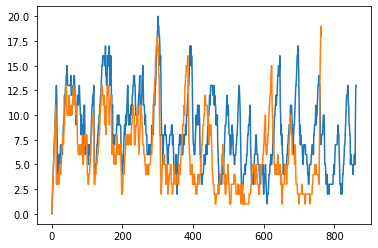

In [57]:
from itertools import chain
import matplotlib.pyplot as plt

darvis_fn = "/home/sofiya/darvis-home/results/essential_graph_edges_darvis.txt"
orbslam_fn = "/home/sofiya/darvis-home/results/essential_graph_edges_orbslam.txt"

darvis_results = {}
orbslam_results = {}

def read(file, results):
    _max = (0, 0)
    _total_edges = 0.0
    _total_vertices = 0.0
    with open(file, "r") as f:
        for line in f:
            v_id, edge_num = line.split(":")
            v_id = int(v_id)
            edge_num = int(edge_num)
            
            results[v_id] = edge_num
            
            _total_vertices += 1
            _total_edges += edge_num
            
            if edge_num > _max[0]:
                _max = (v_id, edge_num)
                
    print("total edges", _total_edges)
    print("total vertices", _total_vertices)
    print("avg", _total_edges / _total_vertices)
    print("max", _max)


def plot(results):
    x = []
    y = []
    for key, value in sorted(results.items(), key=lambda e: e):
        x.append(key)
        y.append(value)
    
    plt.plot(x, y)        
    
print("darvis")
read(darvis_fn, darvis_results)
plot(darvis_results)

print()
print("orbslam")
read(orbslam_fn, orbslam_results)
plot(orbslam_results)
